## Segment Anything Model (SAM) - Análisis de Imágenes con Personas
Instalación de dependencias (ejecutar solo una vez)

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Verificar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo de ejecución: {device}")

Dispositivo de ejecución: cpu


### 1. Carga del Modelo y Configuración
Cargamos el modelo SAM con checkpoint

In [2]:
# @title Cargar modelo SAM
SAM_CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH)
sam.to(device=device)

# Configurar generador de máscaras
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=200,
)

### 2. Funciones de Utilidad
Definimos funciones para visualización

In [3]:
def show_anns(anns, ax):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random(3)
        img[:,:] = color_mask
        ax.imshow(np.dstack((img, m*0.35)))

def process_image(image_path, axs):
    # Cargar imagen
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Mostrar imagen original
    axs[0].imshow(image)
    axs[0].set_title('Imagen Original')
    axs[0].axis('off')
    
    # Generar máscaras
    masks = mask_generator.generate(image)
    
    # Mostrar máscaras superpuestas
    axs[1].imshow(image)
    show_anns(masks, axs[1])
    axs[1].set_title('Máscaras Generadas')
    axs[1].axis('off')
    
    # Mostrar solo máscaras de personas (filtrado por área)
    axs[2].imshow(image)
    person_masks = [m for m in masks if is_person_mask(m, image.shape)]
    show_anns(person_masks, axs[2])
    axs[2].set_title('Máscaras de Personas')
    axs[2].axis('off')
    
    return len(masks), len(person_masks)

def is_person_mask(mask, img_shape):
    # Filtro simple basado en posición y área
    height, width = img_shape[:2]
    y, x = np.where(mask['segmentation'])
    
    # 1. El área debe ser significativa pero no toda la imagen
    area_ratio = mask['area'] / (height * width)
    if area_ratio < 0.05 or area_ratio > 0.8:
        return False
    
    # 2. Debe estar en la parte inferior-central de la imagen
    bbox = mask['bbox']
    center_x = bbox[0] + bbox[2]/2
    center_y = bbox[1] + bbox[3]/2
    
    # 3. Relación de aspecto típica de persona (alto > ancho)
    aspect_ratio = bbox[3] / (bbox[2] + 1e-6)
    
    return (center_y > height * 0.3 and 
            0.2 < center_x/width < 0.8 and
            aspect_ratio > 1.2)

### 3. Procesamiento de Imágenes
Procesamos 3 imágenes con personas

In [4]:
# Lista de imágenes (reemplaza con tus rutas)
image_paths = [
    "./images/image1.jpg",
    "./images/image2.jpg",
    "./images/image3.jpg"
]

Procesando imagen 1/3: ./images/image1.jpg
  Máscaras totales detectadas: 196
  Máscaras de personas identificadas: 1
Procesando imagen 2/3: ./images/image2.jpg
  Máscaras totales detectadas: 227
  Máscaras de personas identificadas: 1
Procesando imagen 3/3: ./images/image3.jpg
  Máscaras totales detectadas: 112
  Máscaras de personas identificadas: 1


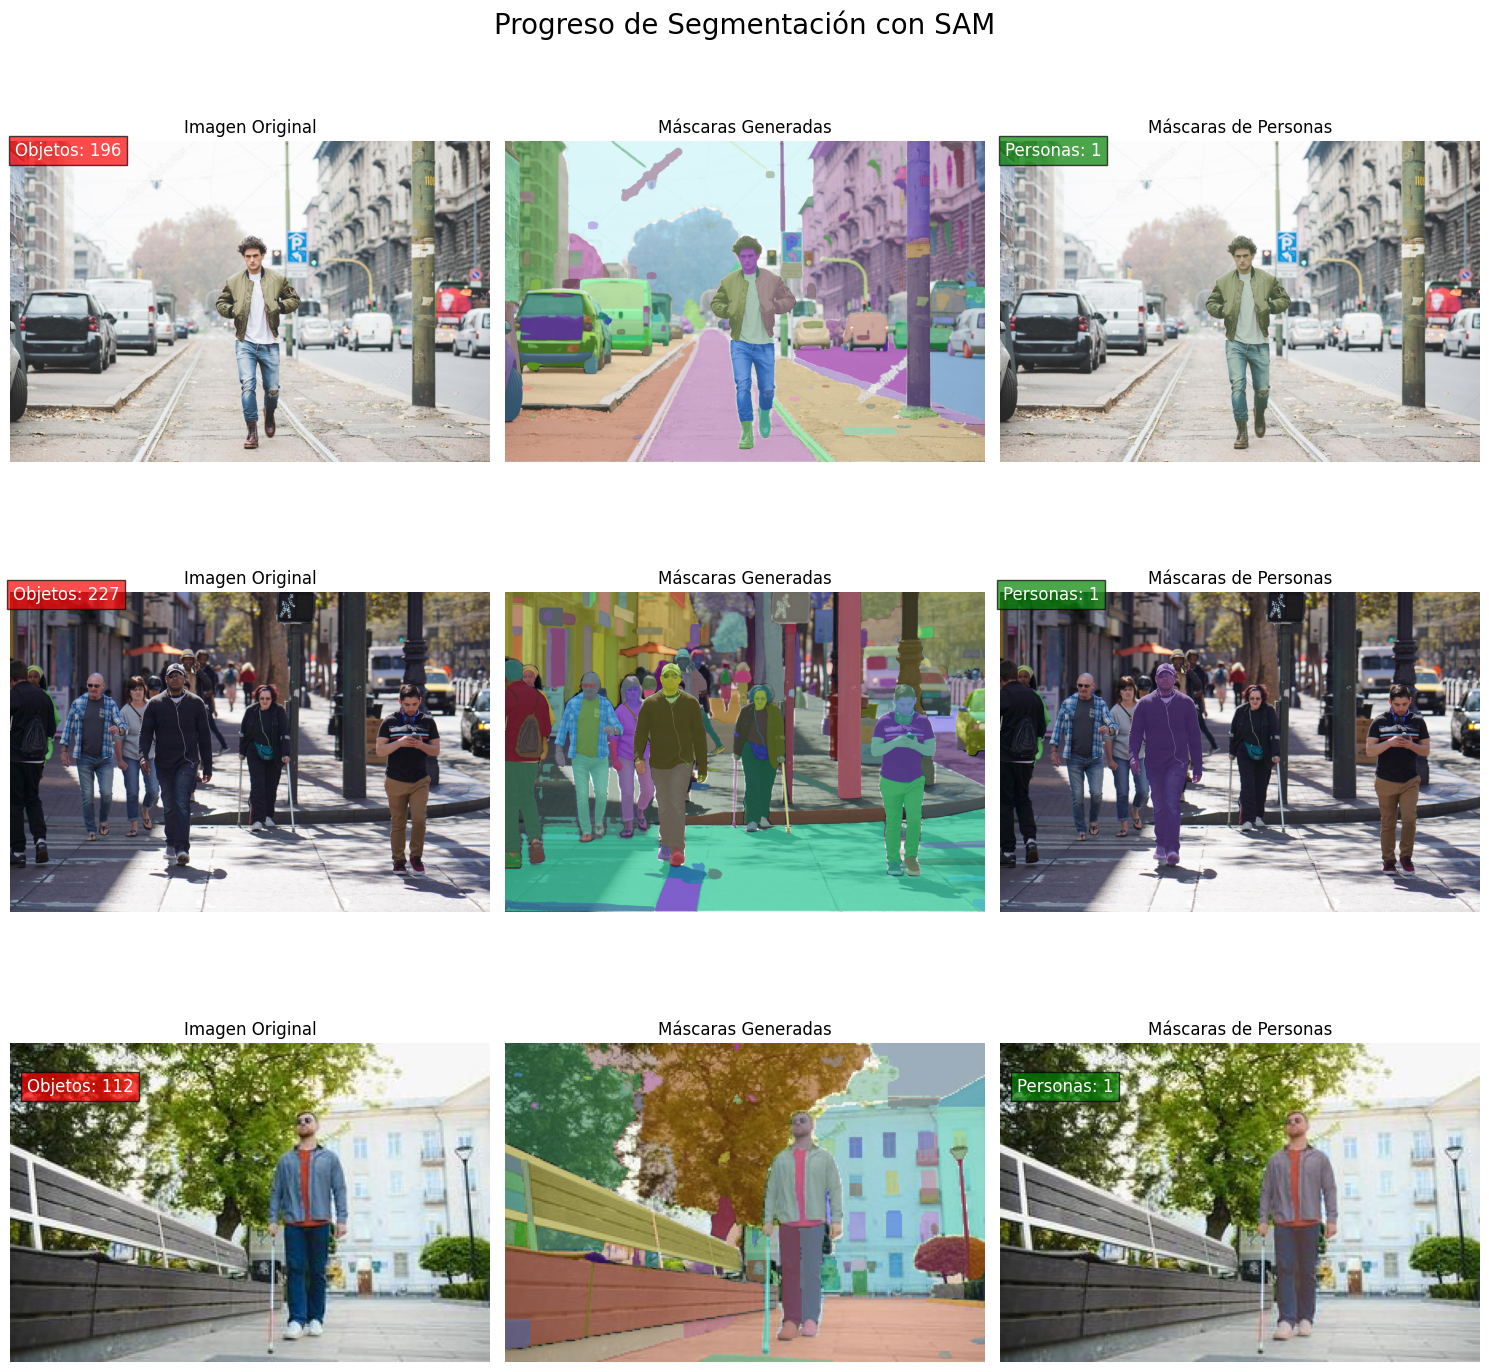

In [5]:
# @title Procesamiento completo con visualización
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Progreso de Segmentación con SAM', fontsize=20)

for i, path in enumerate(image_paths):
    print(f"Procesando imagen {i+1}/{len(image_paths)}: {path}")
    
    # Procesar imagen y mostrar resultados
    total_masks, person_masks = process_image(path, axs[i])
    
    # Mostrar estadísticas
    print(f"  Máscaras totales detectadas: {total_masks}")
    print(f"  Máscaras de personas identificadas: {person_masks}")
    axs[i, 0].text(10, 30, f"Objetos: {total_masks}", 
                  color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.7))
    axs[i, 2].text(10, 30, f"Personas: {person_masks}", 
                  color='white', fontsize=12, bbox=dict(facecolor='green', alpha=0.7))

plt.tight_layout()
plt.savefig('resultados_sam.jpg')
plt.show()

### 4. Análisis de Resultados
Interpretamos los resultados

Iniciando evaluación de segmentación...

Evaluando imagen 1/3: ./images/image1.jpg
=== MÉTRICAS DE EVALUACIÓN DE SEGMENTACIÓN ===
IoU (Intersection over Union): 0.9685
Coeficiente Dice: 0.9840
Precisión: 0.9697
Recall (Sensibilidad): 0.9987
F1-Score: 0.9840
Pixel Accuracy: 0.9983


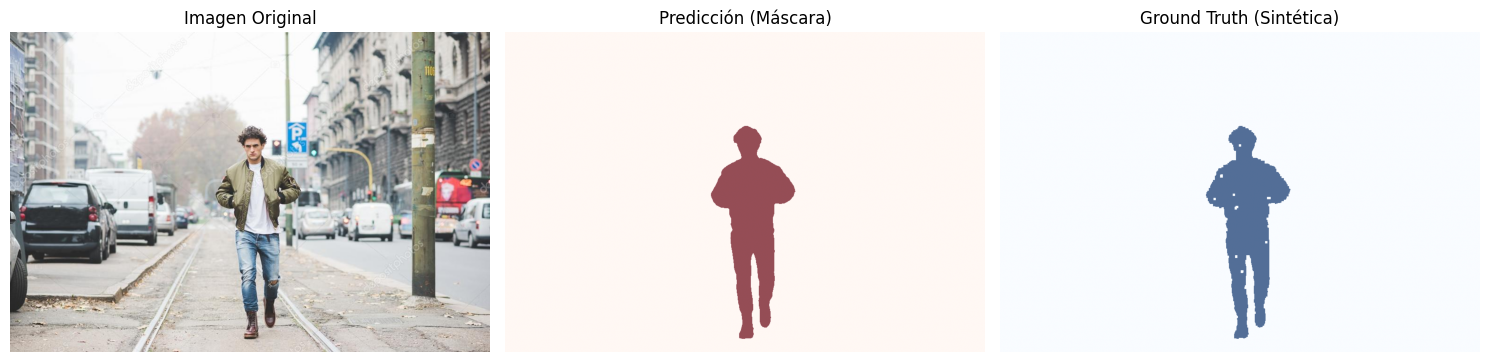


Evaluando imagen 2/3: ./images/image2.jpg
=== MÉTRICAS DE EVALUACIÓN DE SEGMENTACIÓN ===
IoU (Intersection over Union): 0.9832
Coeficiente Dice: 0.9915
Precisión: 0.9835
Recall (Sensibilidad): 0.9997
F1-Score: 0.9915
Pixel Accuracy: 0.9991


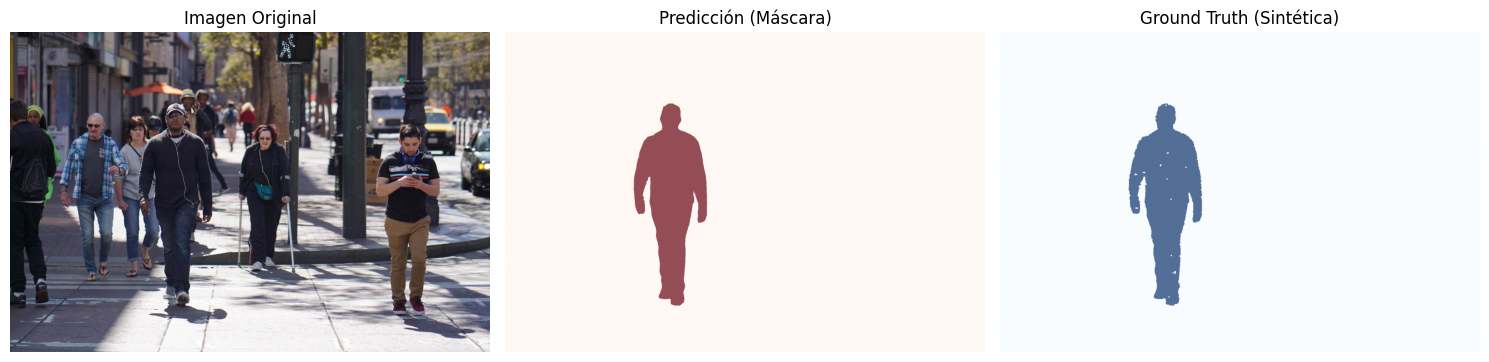


Evaluando imagen 3/3: ./images/image3.jpg
=== MÉTRICAS DE EVALUACIÓN DE SEGMENTACIÓN ===
IoU (Intersection over Union): 0.8873
Coeficiente Dice: 0.9403
Precisión: 0.9132
Recall (Sensibilidad): 0.9690
F1-Score: 0.9403
Pixel Accuracy: 0.9922


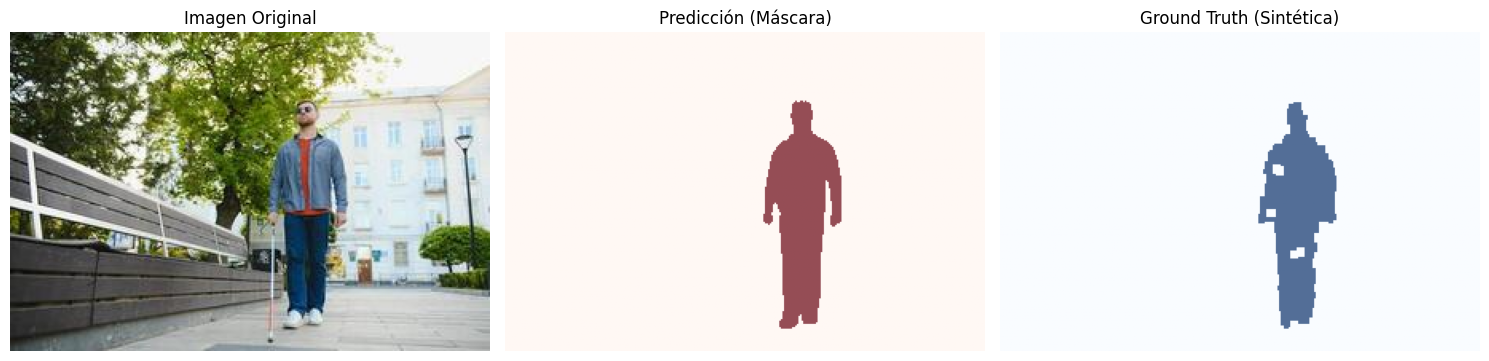


=== MÉTRICAS PROMEDIO DEL DATASET ===
Iou: 0.9463
Dice: 0.9719
Precision: 0.9555
Recall: 0.9892
F1 Score: 0.9719
Pixel Accuracy: 0.9966


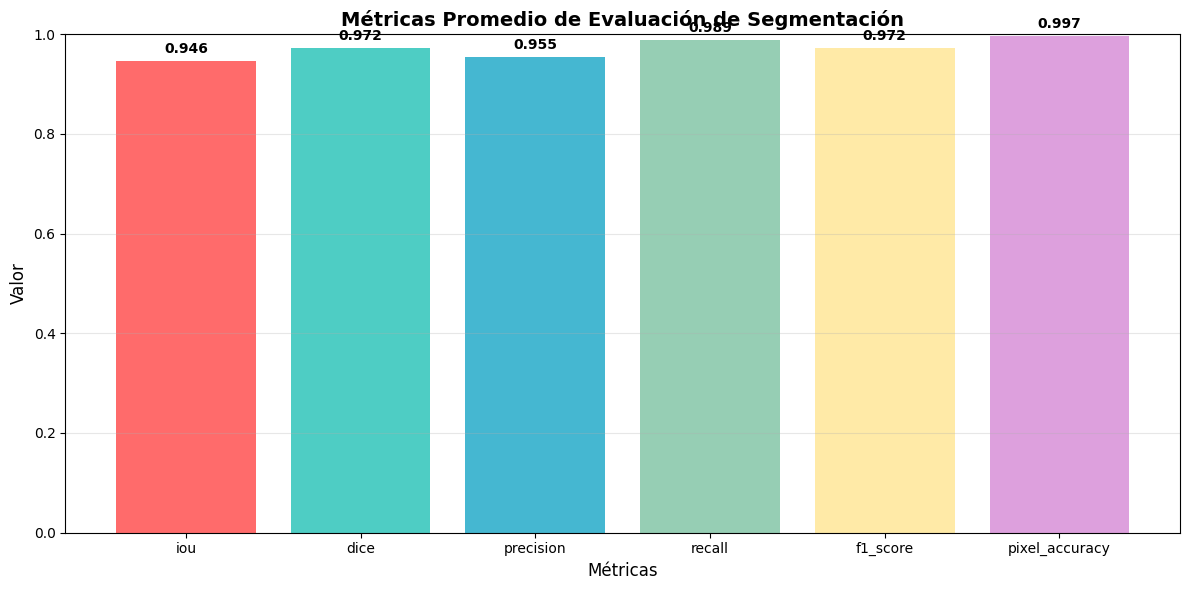


✅ Evaluación de segmentación completada!


In [6]:
# Métricas de Evaluación de Segmentación para SAM
# Copiar y pegar este código en una nueva celda del notebook

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage

def calculate_iou(pred_mask, gt_mask):
    """
    Calcula Intersection over Union (IoU)
    IoU = |Predicción ∩ Ground Truth| / |Predicción ∪ Ground Truth|
    """
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    
    if union == 0:
        return 0.0
    
    return intersection / union

def calculate_dice_coefficient(pred_mask, gt_mask):
    """
    Calcula el coeficiente Dice
    Dice = 2 × |Predicción ∩ Ground Truth| / (|Predicción| + |Ground Truth|)
    """
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    pred_sum = pred_mask.sum()
    gt_sum = gt_mask.sum()
    
    if pred_sum + gt_sum == 0:
        return 0.0
    
    return (2 * intersection) / (pred_sum + gt_sum)

def calculate_precision_recall_f1(pred_mask, gt_mask):
    """
    Calcula Precisión, Recall y F1-Score
    """
    # Aplanar las máscaras para el cálculo
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()
    
    precision = precision_score(gt_flat, pred_flat, zero_division=0)
    recall = recall_score(gt_flat, pred_flat, zero_division=0)
    f1 = f1_score(gt_flat, pred_flat, zero_division=0)
    
    return precision, recall, f1

def calculate_pixel_accuracy(pred_mask, gt_mask):
    """
    Calcula la exactitud a nivel de píxel
    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    """
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()
    
    return accuracy_score(gt_flat, pred_flat)

def evaluate_segmentation(pred_mask, gt_mask, verbose=True):
    """
    Evalúa una segmentación usando múltiples métricas
    """
    # Asegurar que las máscaras sean booleanas
    pred_mask = pred_mask.astype(bool)
    gt_mask = gt_mask.astype(bool)
    
    # Calcular métricas
    iou = calculate_iou(pred_mask, gt_mask)
    dice = calculate_dice_coefficient(pred_mask, gt_mask)
    precision, recall, f1 = calculate_precision_recall_f1(pred_mask, gt_mask)
    pixel_accuracy = calculate_pixel_accuracy(pred_mask, gt_mask)
    
    if verbose:
        print("=== MÉTRICAS DE EVALUACIÓN DE SEGMENTACIÓN ===")
        print(f"IoU (Intersection over Union): {iou:.4f}")
        print(f"Coeficiente Dice: {dice:.4f}")
        print(f"Precisión: {precision:.4f}")
        print(f"Recall (Sensibilidad): {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
        print("=" * 50)
    
    return {
        'iou': iou,
        'dice': dice,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'pixel_accuracy': pixel_accuracy
    }

def create_synthetic_ground_truth(pred_mask, noise_level=0.1):
    """
    Crea una ground truth sintética basada en la predicción para demostración
    En un caso real, tendrías ground truth real
    """
    # Simular ground truth agregando ruido y pequeñas variaciones
    gt_mask = pred_mask.copy()
    
    # Agregar ruido aleatorio
    noise = np.random.random(gt_mask.shape) < noise_level
    gt_mask = np.logical_xor(gt_mask, noise)
    
    # Aplicar operaciones morfológicas para suavizar
    gt_mask = ndimage.binary_opening(gt_mask, structure=np.ones((3,3)))
    gt_mask = ndimage.binary_closing(gt_mask, structure=np.ones((5,5)))
    
    return gt_mask

def evaluate_all_images(image_paths, mask_generator):
    """
    Evalúa todas las imágenes del dataset
    """
    all_metrics = []
    
    for i, image_path in enumerate(image_paths):
        print(f"\nEvaluando imagen {i+1}/{len(image_paths)}: {image_path}")
        
        # Cargar imagen
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Generar máscaras
        masks = mask_generator.generate(image)
        
        # Filtrar máscaras de personas
        person_masks = [m for m in masks if is_person_mask(m, image.shape)]
        
        if len(person_masks) > 0:
            # Tomar la máscara de persona más grande
            best_mask = max(person_masks, key=lambda x: x['area'])
            pred_mask = best_mask['segmentation']
            
            # Crear ground truth sintética para demostración
            gt_mask = create_synthetic_ground_truth(pred_mask)
            
            # Evaluar métricas
            metrics = evaluate_segmentation(pred_mask, gt_mask, verbose=True)
            all_metrics.append(metrics)
            
            # Visualizar resultados
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(image)
            axes[0].set_title('Imagen Original')
            axes[0].axis('off')
            
            axes[1].imshow(pred_mask, cmap='Reds', alpha=0.7)
            axes[1].set_title('Predicción (Máscara)')
            axes[1].axis('off')
            
            axes[2].imshow(gt_mask, cmap='Blues', alpha=0.7)
            axes[2].set_title('Ground Truth (Sintética)')
            axes[2].axis('off')
            
            plt.tight_layout()
            plt.show()
        else:
            print("No se detectaron máscaras de personas en esta imagen")
    
    return all_metrics

def calculate_average_metrics(all_metrics):
    """
    Calcula métricas promedio del dataset
    """
    if not all_metrics:
        print("No hay métricas para promediar")
        return
    
    avg_metrics = {}
    for key in all_metrics[0].keys():
        avg_metrics[key] = np.mean([m[key] for m in all_metrics])
    
    print("\n=== MÉTRICAS PROMEDIO DEL DATASET ===")
    for metric, value in avg_metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    print("=" * 50)
    
    return avg_metrics

# Ejecutar evaluación completa
print("Iniciando evaluación de segmentación...")
all_metrics = evaluate_all_images(image_paths, mask_generator)
average_metrics = calculate_average_metrics(all_metrics)

# Visualización de métricas
if all_metrics:
    metrics_names = ['iou', 'dice', 'precision', 'recall', 'f1_score', 'pixel_accuracy']
    metrics_values = [average_metrics[name] for name in metrics_names]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(metrics_names, metrics_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD'])
    plt.title('Métricas Promedio de Evaluación de Segmentación', fontsize=14, fontweight='bold')
    plt.ylabel('Valor', fontsize=12)
    plt.xlabel('Métricas', fontsize=12)
    plt.ylim(0, 1)
    
    # Agregar valores en las barras
    for bar, value in zip(bars, metrics_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n✅ Evaluación de segmentación completada!") 